In [1]:
# imports
import numpy as np
import random
import math
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
# Read data functions
def string_to_spin(string):
    """
    Convert string of 0 and 1 to a np array of spins (-1, 1):
    0 -> -1
    1 -> +1
    :param string: String: original string.
    :return: np.array: Spins.
    """
    return (np.array(list(map(int, list(string)))) * 2 - 1)

def read_configurations(name, n):
    """
    Reads a file and returns a np array with the spin configuration.
    :param name: String: Name of the file.
    :param n: Int: Number of spins.
    :return: np.array: Matrix of shape (Data_number, num_spins).
    """
    spins = np.array([])
    filepath = name
    with open(filepath, 'r') as fp:
        s = fp.readlines()  
    spins = np.array([string_to_spin(e.rstrip()) for e in s]).flatten()
    return np.reshape(spins, (int(len(spins)/n), n)).astype('int')

def read_j_coef(name, n):
    """
    Reads a file and returns a np array with the j coefficients.
    :param name: String: Name of the file.
    :param n: Int: Number of spins.
    :return: np.array: Array of shape 2*n.
    """
    j = np.zeros((n, 2))
    filepath = name
    with open(filepath) as fp:
        for line in tqdm_notebook(fp.readlines()):
            list_line = line.split()
            if len(list_line) == 2:
                el = list_line[-1]
                list_line[-1] = el[0]
                list_line.append(el[1:])
            s = int(list_line[0])-1
            d = int(list_line[1])-1
            # list line té 3 llocs: numspin, (1 o 2) i el valor de J
            j[s, d] = list_line[-1]
    return j

In [3]:
# get neighbours
def get_spin_neighbours(i, l):
    """
    From a spin i in a lxl grid, gives the neighbours of this spin.
    :param i: Int: Position of the spin.
    :param l: Int: Length of the square grid.
    :return: np.array: Array containing the index of the neighbour spins.
    """
    column = int(i % l)
    row = int(i / l)
    right = int(row * l + (column + 1)%l)
    up = int(((row + 1)%l) * l + column)
    left = int(row * l + (column - 1)%l)
    down = int(((row - 1)%l) * l + column)
    return np.array([right, up, left, down])

def f_nbrs(n):
    l = int(np.sqrt(n))
    return np.array([get_spin_neighbours(i, l) for i in range(n)])

In [4]:
# Pseudolikelihood calculation
def log_pseudolikelihood(data, nbrs, h, j, temp=1, recalculate = True, previous = 0, h_prev=None, j_prev=None, new_row = -1):
    """Sums the rows of the pseudolikelihood"""
    m, n = data.shape
    if recalculate:
        output = 0
        for i in range(n):
            output += log_pseudolikelihood_row(data, h, j, temp, i, nbrs[i])
        return -float(output)/m
    else:
        delta = 0
        for r in new_row:
            delta += float(log_pseudolikelihood_row(data, h_prev, j_prev, temp, r, nbrs[r]) - log_pseudolikelihood_row(data, h, j, temp, r, nbrs[r]))
        return previous + delta/m
        


def log_pseudolikelihood_row(data, h, j, temp, i, nbr):
    """
    Computes the pseudolikelihood for each row i.
    """
    m, n = data.shape
    output = 0
    for mu in range(m):
        output += math.log(1 + data[mu, i] * math.tanh(float(h[i])/temp + multiply_j_spin_neighbours(j, data[mu, :], i, nbr)/temp))
    return output

def multiply_j_spin_neighbours(j, spins, i, nbr):
    n, d = j.shape
    subsum = 0
    for k in range(d):
        subsum += spins[nbr[k]] * j[i, k] + spins[nbr[k + d]] * j[nbr[k + d], k] 
    return float(subsum)

In [5]:
def hamiltonian(spins, h, j):
    hamiltonian = 0
    n, d = j.shape
    l = int(np.sqrt(n))
    for i in range(n):
        subsum = 0
        for k in range(d):
            subsum += spins[get_spin_neighbours(i, l)[k]] * j[i, k]
        hamiltonian += spins[i] * subsum
    hamiltonian += np.dot(h, spins)
    return -hamiltonian

In [6]:
# Create random h and J of given dimension
def get_random_h_j(n, d=2):
    h = np.random.uniform(-1, 1, size=n)
    j = np.random.uniform(-1, 1, size=(n,d))
    return h, j

def mean_error(h, j, hp, jp, magnetic_field=True):
    n, = h.shape
    numerator = np.linalg.norm(flat_matrix(j) - flat_matrix(jp))**2 + np.linalg.norm(h-hp)**2
    denominator = np.linalg.norm(flat_matrix(jp))**2 + np.linalg.norm(hp)**2
    return np.sqrt(numerator/denominator)


def neighbour_uniform(s, delta=0.5):
    lower = max(s - delta, -1.)
    upper = min(s + delta, 1.)
    return np.random.uniform(lower, upper)

def random_change_h_j_row(h, j, nbrs, delta=0.5, magnetic_field=True):
    if magnetic_field:
        h_new = np.copy(h)
        j_new = np.copy(j)
        n, d = j_new.shape
        column = np.random.randint(0, n)
        row = np.random.randint(0, d+1)
        if row == d:
            # h must be changed
            h_new[column] = neighbour_uniform(h_new[column], delta)
            return h_new, j_new, (column,)
        else:
            # j must be changed
            j_new[column, row] = neighbour_uniform(j_new[column, row], delta)
            return h_new, j_new, (column, nbrs[column][row])
    else:
        h_new = np.zeros_like(h)
        j_new = np.copy(j)
        n, d = j_new.shape
        column = np.random.randint(0, n)
        row = np.random.randint(0, d)
        # j must be changed
        j_new[column, row] = neighbour_uniform(j_new[column, row], delta)
        return h_new, j_new, (column, nbrs[column][row])
    
def energy(temp, func, func_new):
    return math.exp(-(func_new - func) / temp)

In [7]:
# Simulated annealing

def simulated_algorithm_min_multi(data, hreal, jreal, real_temp=1, magnetic_field=True, values=None, mc_steps=800, temp_ini=3):
    start = timeit.default_timer()
 
    m, n = data.shape
    if values is None:
        h0, j0 = get_random_h_j(n)
    else:
        h0, j0 = values
    print('Time values: ', timeit.default_timer() - start) 
    h_iter, j_iter = h0, j0
    h_min, j_min = h0, j0
    nbrs = f_nbrs(n)
    print('Time nbrs: ', timeit.default_timer() - start) 
    func_iter = log_pseudolikelihood(data, nbrs, h_iter, j_iter, temp=real_temp)
    print('Time log: ', timeit.default_timer() - start) 
    func_min = func_iter
    rec = False
    error = []
    min_vals = []
    max_num_iters = int(2*n*mc_steps)
    print('Time: start', timeit.default_timer() - start) 
    for k in tqdm_notebook(range(max_num_iters), leave=True):
        if k%200 == 0:
            rec = True
        error.append(mean_error(h_iter, j_iter, hreal, jreal, magnetic_field=magnetic_field))
        min_vals.append(func_iter)
        temp = temp_ini * (1. - float(k) / (max_num_iters))
        h_new, j_new, row = random_change_h_j_row(h_iter, j_iter, nbrs, delta=0.3, magnetic_field=magnetic_field)
        func_new = log_pseudolikelihood(data, nbrs, h_new, j_new, temp=real_temp, recalculate=rec, previous=func_iter, h_prev=h_iter, j_prev=j_iter, new_row=row)
        rec = False
        if func_new < func_iter:
            h_iter, j_iter = h_new, j_new
            func_iter = func_new
            if func_new < func_min:
                h_min, j_min = h_new, j_new
                func_min = func_new
        elif random.random() < energy(temp, func_iter, func_new):
            h_iter, j_iter = h_new, j_new
            func_iter = func_new
    #print(h_iter, j_iter, func_iter)
    #print(h_min, j_min, func_min)
    print('Time: end', timeit.default_timer() - start) 
    output_value = find_local_minimum_multi(data, nbrs, h_min, j_min, func_min, real_temp=real_temp, initial_delta=0.3, max_iter=int(max_num_iters/10), magnetic_field=magnetic_field)
    return output_value, error, min_vals


def find_local_minimum_multi(data, nbrs, h_ini, j_ini, func_ini, real_temp=1, max_iter=1000, initial_delta=0.5, magnetic_field=True):
    h_min, j_min = h_ini, j_ini
    func_min = func_ini
    for k in tqdm_notebook(range(max_iter), leave=False):
        delta = initial_delta * (max_iter - k) / max_iter
        h_new, j_new, row = random_change_h_j_row(h_min, j_min, nbrs, delta=delta, magnetic_field=magnetic_field)
        func_new = log_pseudolikelihood(data, nbrs, h_new, j_new, temp=real_temp, recalculate=False, previous=func_min, h_prev=h_min, j_prev=j_min, new_row=row)
        if func_new < func_min:
            h_min, j_min = h_new, j_new
            func_min = func_new
    return h_min, j_min, func_min

In [8]:
def flat_matrix(a):
    return a.flatten()

In [9]:
def write_error_to_file(filename, error):
    f = open(filename, "w+")
    for e in error:
        f.write(str(e)+"\n")
    f.close()
def read_error_from_file(filename):
    with open(filename, 'r') as fp:
        s = fp.readlines()
    return np.array([e.strip() for e in s], dtype='float')

In [10]:
def write_arr_to_file(filename, arr1, arr2):
    f = open(filename, "w+")
    for e1, e2 in zip(arr1, arr2):
        f.write(str(e1)+' '+str(e2)+"\n")
    f.close()
def read_arr_from_file(filename):
    arr1 = []
    arr2 = []
    with open(filename, 'r') as fp:
        s = fp.readlines()
    for e in s:
        arr1.append(e.split()[0])
        arr2.append(e.split()[1])

    return np.array(arr1, dtype='float'), np.array(arr2, dtype='float')

In [11]:
size_sample = 25000
max_iterations = 200
n = 16
t1, t2, t3 = 0.5, 1.08304286, 2.0
j1 = read_j_coef('L4/sample2/bonds.dat', n)
h = np.zeros(n)
spins = read_configurations('L4/sample2/configurations_T3.dat', n)
spins = spins[::4]# en el cas de n=16
sample1 = spins[np.random.choice(spins.shape[0], size=size_sample, replace=False), :]
print(sample1.shape)


(25000, 16)


In [12]:
start = timeit.default_timer()
result1 = simulated_algorithm_min_multi(sample1, h, j1, real_temp=t3, mc_steps=max_iterations, magnetic_field=False)
print('TOTAL TIME:', timeit.default_timer() - start)

Time values:  5.8649000038712984e-05
Time nbrs:  0.0026477030000933155
Time log:  15.357990584999925
Time: start 15.361026249999895



Time: end 18725.755374728


TOTAL TIME: 20453.833784441


In [13]:
write_error_to_file('L4_T3_S2_error.txt', result1[1])
write_arr_to_file('M25000_L4_T3_S2_j.txt', flat_matrix(j1), flat_matrix(result1[0][1]))

In [14]:
#write_error_to_file('L4_T1_S1_error_2.txt', result1[1])
#write_error_to_file('L4_T1_S2_error_2.txt', result2[1])
#write_error_to_file('L4_T1_S3_error_2.txt', result3[1])

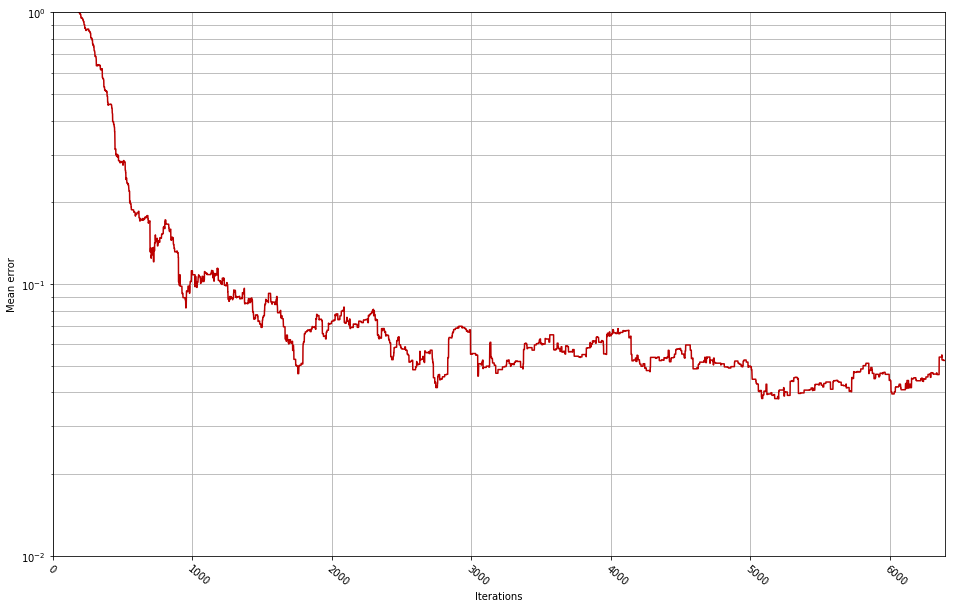

In [15]:
x = np.arange(len(result1[1]))


plt.figure(figsize = (16, 10))
ax = plt.axes()
#plt.title('Mean error vs iterations for M=25000 samples of N=4x4 spin configurations')
plt.xlabel('Iterations')
plt.ylabel('Mean error')
plt.plot(x, result1[1], color='#bb0000')
#plt.plot(x, result2[1], color='#00bb00')
#plt.plot(x, result3[1], color='#0000bb')
plt.yscale('log')
plt.ylim(1e-2, 1)
plt.xlim(0, np.max(x))
plt.xticks(range(0, np.max(x) + 2, 1000))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-40, ha="left", rotation_mode="anchor")
plt.grid(True, which='both')
#plt.savefig('error_L4_s3_T3_15000it_1.png')
plt.show()

In [16]:
print('L4_T1_S1_error:{}'.format(mean_error(h, result1[0][1], h, j1)))
#print('L4_T1_S2_error:{}'.format(mean_error(h, result2[0][1], h, j2)))
#print('L4_T1_S3_error:{}'.format(mean_error(h, result3[0][1], h, j3)))

L4_T1_S1_error:0.026183252534278917


In [ ]:
from matplotlib import rc
import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [ ]:
plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.title('L=4, $T=T_1$', fontsize=45, y=1.005)
plt.xlabel('$J^{0}_{ij}$', rotation=0, fontsize=45)
plt.ylabel('$J_{ij}$', rotation=0, fontsize=45)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.5)
plt.plot((-1, 1), (-1,1), color='#55ff00', label='y=x', zorder=1, linewidth=5, alpha=1)
plt.scatter(flat_matrix(j1), flat_matrix(result1[0][1]), color='#ee2222', label='Sample 1', zorder=6, marker="o", s=300)
#plt.scatter(flat_matrix(j2), flat_matrix(result2[0][1]), color='#E8B201', label='Sample 2', zorder=5, marker="v", s=300)
#plt.scatter(flat_matrix(j3), flat_matrix(result3[0][1]), color='#2222ee', label='Sample 3', zorder=4, marker="^", s=300)
#plt.scatter(flat_sym_matrix(j8), flat_sym_matrix(result8[1]), color='#009900', label='N=8', zorder=5, marker="v")
#plt.scatter(flat_sym_matrix(j12), flat_sym_matrix(result12[1]), color='#2222ee', label='N=12', zorder=4, marker="^")
#plt.scatter(flat_sym_matrix(j16), flat_sym_matrix(result16[1]), color='#E8B201', label='N=16', zorder=3, marker="s")
#plt.scatter(flat_sym_matrix(j20), flat_sym_matrix(result20[1]), color='#B300FF', label='N=20', zorder=2, marker="D")

plt.ylim(-1, 1)
plt.xlim(-1, 1)

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax.tick_params(which='both', width=4)
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
#plt.grid()
#plt.legend()
#plt.savefig('L4_T1.png', bbox_inches = 'tight')
plt.show()



In [ ]:
#write_arr_to_file('M25000_L4_T1_S1_j.txt', flat_matrix(j1), flat_matrix(result1[0][1]))
#write_arr_to_file('M25000_L4_T1_S2_j.txt', flat_matrix(j2), flat_matrix(result2[0][1]))
#write_arr_to_file('M25000_L4_T1_S3_j.txt', flat_matrix(j3), flat_matrix(result3[0][1]))

In [ ]:
from skimage import io, exposure, color, img_as_float, img_as_int, img_as_uint, img_as_ubyte
image = io.imread('test2.png')
def two_images(img1, img2, savename):
    io.imsave(savename, np.hstack((img1, img2)))
def three_images(img1, img2, img3, savename):
    io.imsave(savename, np.vstack((img1, img2, img3)))
two_images(image, image, 'test_joined.png')
image = io.imread('test_joined.png')
three_images(image, image, image, 'test_joined_final.png')